In [1]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 450kB 52.6MB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=a82778cd9b29f27563b925f38b0f114fa522aaf8b11c5b5a388b44c17e9c71ef
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installa

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [5]:
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
trofi=pd.read_csv('drive/My Drive/datasets/TroFi_formatted_all3737.csv')

In [7]:
trofi.drop(["verb", "verb_idx"], inplace=True, axis=1)
trofi.head()

,sentence,label
0,An Energy Department spokesman says the sulfur...,0
1,The yellow beta carotene pigment absorbs blue ...,0
2,"This time , the ground absorbed the shock wave...",0
3,'' Vitamins could be passed right out of the b...,0
4,"As Eliot wrote : '' In a warm haze , the sultr...",0


In [8]:
trofi.describe()

,label
count,3737.000000
mean,0.435376
std,0.495872
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
duplicatedRow = trofi[trofi.duplicated()]
print(duplicatedRow[:5])

                                              sentence  label
44   Here in Masaya , supporters of a group known a...      0
110  Whether these dancers could ever meet the requ...      0
111  Television commercials expected to air in mid ...      0
113  Mr. Waters sets his sights on the '' hairhoppe...      0
118  With their wives and girlfriends in Mexico , i...      0


In [10]:
trofi.groupby('label').describe().T

label                                                            0                                                  1
sentence count                                                2110                                               1627
         unique                                               2028                                               1593
         top     A revenue passenger mile is one paying passeng...  Traditions die hard , and the Fed has n't shak...
         freq                                                   15                                                  2

In [12]:
# get all the metaphor and non metaphor sentences
non_metaphor = trofi[trofi.label ==0]
metaphor = trofi[trofi.label==1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of non metaphor and metaphor sentence')

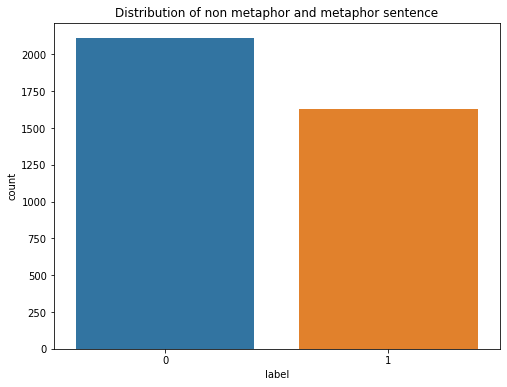

In [13]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(trofi.label)
plt.title('Distribution of non metaphor and metaphor sentence')

In [14]:
# Percentage of metaphore sentence
(len(metaphor)/len(non_metaphor))*100

77.1090047393365

In [15]:
# one way to fix it is to downsample the non metaphor sentences
non_metaphor_df = non_metaphor.sample(n = len(metaphor), random_state = 44)
metaphor_df = metaphor

In [16]:
print(non_metaphor_df.shape, metaphor_df.shape)

(1627, 2) (1627, 2)


In [17]:
df = non_metaphor_df.append(metaphor_df).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentence types')

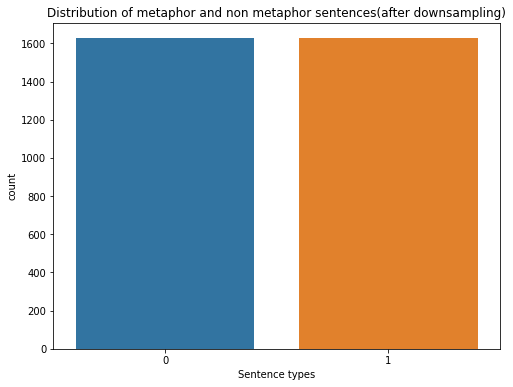

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('Distribution of metaphor and non metaphor sentences(after downsampling)')
plt.xlabel('Sentence types')

In [19]:
# Get length column for each text
df['text_length'] = df['sentence'].apply(len)

#Calculate average length by label types
labels = df.groupby('label').mean()
labels

,text_length
label,
0,155.355870
1,154.936079


In [20]:
# df['type']= df['label']
label = df['label'].values

In [21]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], label, test_size=0.2, random_state=434)

Tokenization

In [22]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [23]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [24]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 'and': 6,
 'in': 7,
 "''": 8,
 'that': 9,
 "'s": 10,
 'for': 11,
 'is': 12,
 'it': 13,
 'with': 14,
 'on': 15,
 'as': 16,
 'by': 17,
 'he': 18,
 'mr': 19,
 "'": 20,
 'but': 21,
 'at': 22,
 'was': 23,
 'said': 24,
 'from': 25,
 'his': 26,
 'have': 27,
 'has': 28,
 'be': 29,
 'an': 30,
 'are': 31,
 "n't": 32,
 'they': 33,
 'its': 34,
 'will': 35,
 'their': 36,
 'one': 37,
 'this': 38,
 'into': 39,
 'up': 40,
 'who': 41,
 'or': 42,
 'out': 43,
 's': 44,
 'when': 45,
 'would': 46,
 'new': 47,
 'more': 48,
 'were': 49,
 'u': 50,
 'says': 51,
 'which': 52,
 'about': 53,
 'had': 54,
 'year': 55,
 'been': 56,
 'i': 57,
 'than': 58,
 'not': 59,
 'if': 60,
 'over': 61,
 'after': 62,
 'last': 63,
 'some': 64,
 'down': 65,
 'company': 66,
 'could': 67,
 'so': 68,
 'market': 69,
 'off': 70,
 'other': 71,
 'two': 72,
 'all': 73,
 'people': 74,
 'million': 75,
 'because': 76,
 'we': 77,
 'them': 78,
 'may': 79,
 'time': 80,
 'lrb': 81,
 'you': 82,

In [25]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 11066 unique tokens in training data. 


In [26]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [27]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (2603, 50)
Shape of testing tensor:  (651, 50)


In [28]:
# Before padding : first sequence is 22 character long where as second one is 21
len(training_sequences[0]), len(training_sequences[1])

(22, 21)

In [29]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [30]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  1   1  23 204   3   5   1   1  45  18 175   5   1   7   1  76  26   1
   1   1 250   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Normal neural network

In [31]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.5 # dropout
n_dense = 24

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.utils import plot_model

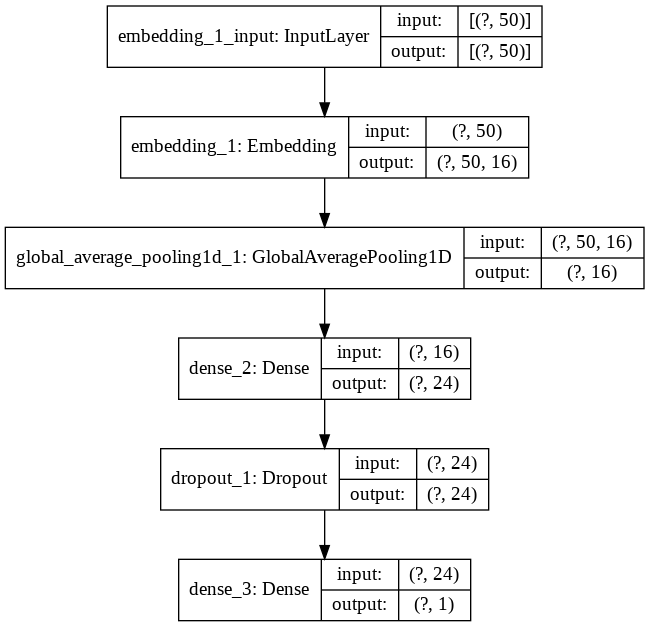

In [35]:
plot_model(model, show_shapes=True)

In [36]:
from tensorflow import keras
# Using Adam optimiser which makes use of momentum to avoid local minima
optim = keras.optimizers.Adam(learning_rate=0.00001)

In [37]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [38]:
num_epochs = 15
early_stop = EarlyStopping(monitor='accuracy', patience=5)
history = model.fit(training_padded, y_train, epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),callbacks =[early_stop], verbose=2)

Train on 2603 samples, validate on 651 samples
Epoch 1/15
2603/2603 - 2s - loss: 0.6930 - accuracy: 0.5098 - val_loss: 0.6932 - val_accuracy: 0.4869
Epoch 2/15
2603/2603 - 0s - loss: 0.6925 - accuracy: 0.5182 - val_loss: 0.6925 - val_accuracy: 0.5361
Epoch 3/15
2603/2603 - 0s - loss: 0.6913 - accuracy: 0.5436 - val_loss: 0.6911 - val_accuracy: 0.5484
Epoch 4/15
2603/2603 - 0s - loss: 0.6887 - accuracy: 0.5701 - val_loss: 0.6886 - val_accuracy: 0.5929
Epoch 5/15
2603/2603 - 0s - loss: 0.6830 - accuracy: 0.6166 - val_loss: 0.6836 - val_accuracy: 0.6083
Epoch 6/15
2603/2603 - 0s - loss: 0.6715 - accuracy: 0.6600 - val_loss: 0.6740 - val_accuracy: 0.6022
Epoch 7/15
2603/2603 - 0s - loss: 0.6557 - accuracy: 0.6531 - val_loss: 0.6643 - val_accuracy: 0.6144
Epoch 8/15
2603/2603 - 0s - loss: 0.6359 - accuracy: 0.6723 - val_loss: 0.6556 - val_accuracy: 0.6098
Epoch 9/15
2603/2603 - 0s - loss: 0.6149 - accuracy: 0.6834 - val_loss: 0.6499 - val_accuracy: 0.6221
Epoch 10/15
2603/2603 - 0s - loss: 

In [39]:
model.evaluate(testing_padded, y_test)

651/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6444886058523175, 0.6466974]

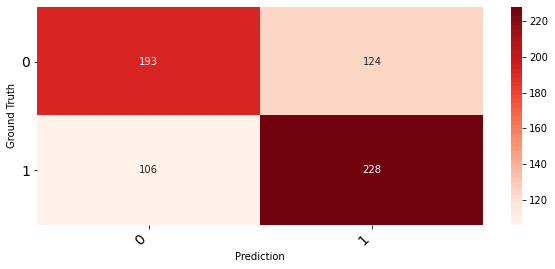

Accuray: 64.67%
ROC-AUC: 0.64573


In [40]:
# predict results
preds = np.round(model.predict(testing_padded)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")

In [41]:
metrics = pd.DataFrame(history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.693045,0.509796,0.693213,0.486943
1,0.692493,0.518248,0.692459,0.536098
2,0.691267,0.543604,0.691088,0.548387
3,0.688673,0.570111,0.688596,0.592934
4,0.682964,0.616596,0.683616,0.608295
5,0.671471,0.660008,0.673996,0.602151
6,0.655682,0.653093,0.664315,0.614439
7,0.635901,0.672301,0.655563,0.609831
8,0.614939,0.683442,0.649924,0.622120
9,0.601667,0.695352,0.645951,0.619048


In [42]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.693045,0.509796,0.693213,0.486943
1,0.692493,0.518248,0.692459,0.536098


In [43]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

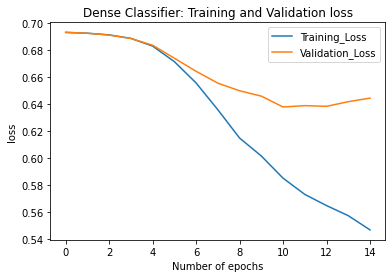

In [44]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

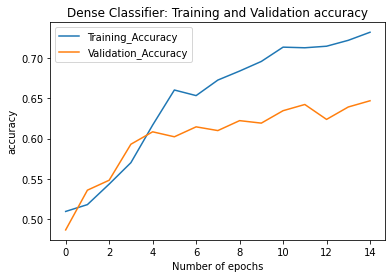

In [45]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

LSTM

In [46]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [47]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))

model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Flatten())

model1.add(Dense(24, activation='relu'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
# model1.add(Dense(1, activation='softmax'))

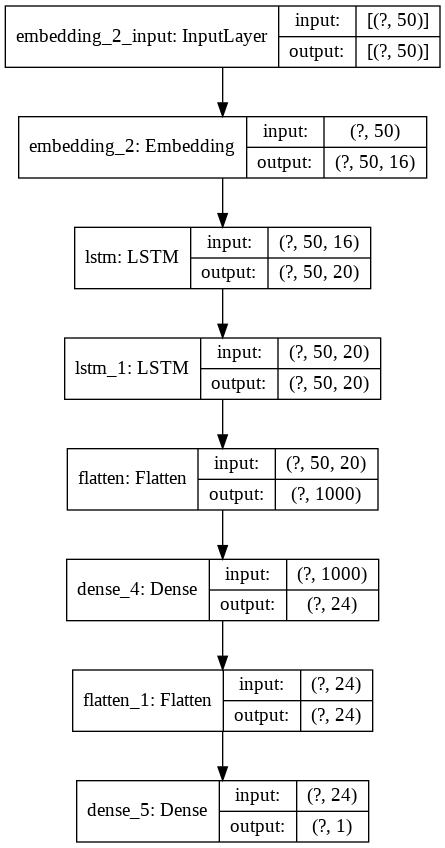

In [48]:
plot_model(model1, show_shapes=True)

In [49]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [51]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model1.fit(training_padded, y_train, epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),callbacks =[early_stop], verbose=2)

Train on 2603 samples, validate on 651 samples
Epoch 1/10
2603/2603 - 9s - loss: 0.6926 - accuracy: 0.5086 - val_loss: 0.6902 - val_accuracy: 0.5392
Epoch 2/10
2603/2603 - 1s - loss: 0.6648 - accuracy: 0.6005 - val_loss: 0.6713 - val_accuracy: 0.5714
Epoch 3/10
2603/2603 - 1s - loss: 0.6112 - accuracy: 0.6604 - val_loss: 0.6531 - val_accuracy: 0.5960
Epoch 4/10
2603/2603 - 1s - loss: 0.5884 - accuracy: 0.6811 - val_loss: 0.6636 - val_accuracy: 0.6037
Epoch 5/10
2603/2603 - 1s - loss: 0.5703 - accuracy: 0.7046 - val_loss: 0.6537 - val_accuracy: 0.6206
Epoch 6/10
2603/2603 - 1s - loss: 0.5536 - accuracy: 0.7149 - val_loss: 0.6710 - val_accuracy: 0.6175
Epoch 7/10
2603/2603 - 1s - loss: 0.5443 - accuracy: 0.7211 - val_loss: 0.6749 - val_accuracy: 0.6006
Epoch 8/10
2603/2603 - 1s - loss: 0.5384 - accuracy: 0.7215 - val_loss: 0.6750 - val_accuracy: 0.6206


In [52]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

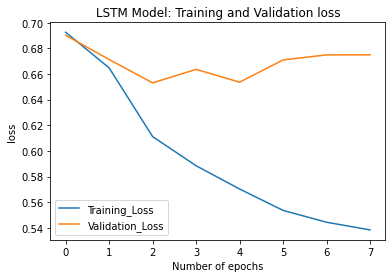

In [53]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

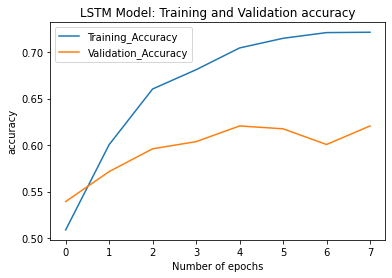

In [54]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

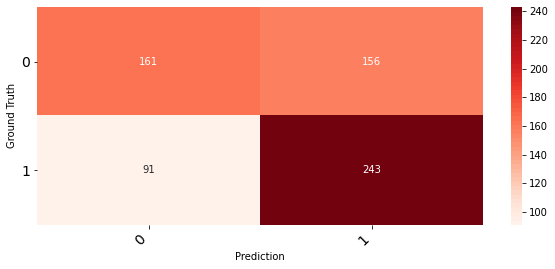

Accuray: 62.058%
ROC-AUC: 0.61772
              precision    recall  f1-score   support

           0       0.64      0.51      0.57       317
           1       0.61      0.73      0.66       334

    accuracy                           0.62       651
   macro avg       0.62      0.62      0.61       651
weighted avg       0.62      0.62      0.62       651



In [55]:
# predict results
preds = np.round(model1.predict(testing_padded)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

Bi-LSTM

In [56]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [57]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2001      
Total params: 15,921
Trainable params: 15,921
Non-trainable params: 0
_________________________________________________________________


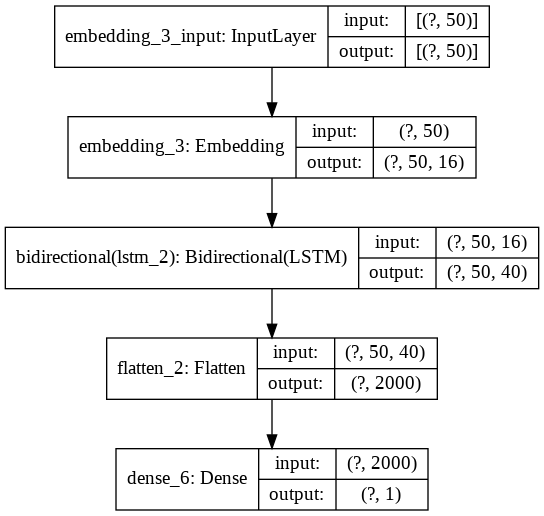

In [58]:
plot_model(model2, show_shapes=True)

In [59]:
num_epochs = 20
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model2.fit(training_padded, y_train, epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),callbacks =[early_stop], verbose=2)

Train on 2603 samples, validate on 651 samples
Epoch 1/20
2603/2603 - 4s - loss: 0.6938 - accuracy: 0.4914 - val_loss: 0.6939 - val_accuracy: 0.4869
Epoch 2/20
2603/2603 - 1s - loss: 0.6858 - accuracy: 0.5667 - val_loss: 0.6752 - val_accuracy: 0.5791
Epoch 3/20
2603/2603 - 1s - loss: 0.6265 - accuracy: 0.6596 - val_loss: 0.6670 - val_accuracy: 0.6160
Epoch 4/20
2603/2603 - 1s - loss: 0.5759 - accuracy: 0.6927 - val_loss: 0.6864 - val_accuracy: 0.5914
Epoch 5/20
2603/2603 - 1s - loss: 0.5512 - accuracy: 0.7134 - val_loss: 0.6751 - val_accuracy: 0.6052
Epoch 6/20
2603/2603 - 1s - loss: 0.5126 - accuracy: 0.7449 - val_loss: 0.7202 - val_accuracy: 0.5929
Epoch 7/20
2603/2603 - 1s - loss: 0.4873 - accuracy: 0.7507 - val_loss: 0.7285 - val_accuracy: 0.5776
Epoch 8/20
2603/2603 - 1s - loss: 0.4590 - accuracy: 0.7706 - val_loss: 0.7823 - val_accuracy: 0.6144


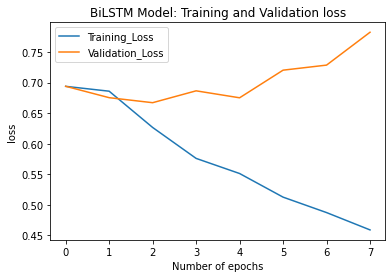

In [60]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

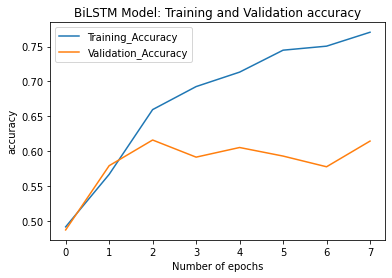

In [61]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

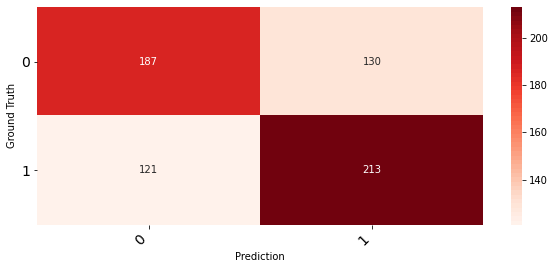

Accuray: 61.443999999999996%
ROC-AUC: 0.61381
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       317
           1       0.62      0.64      0.63       334

    accuracy                           0.61       651
   macro avg       0.61      0.61      0.61       651
weighted avg       0.61      0.61      0.61       651



In [62]:
# predict results
preds = np.round(model2.predict(testing_padded)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

In [63]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, y_test)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, y_test)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, y_test)} " )

651/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================